<a href="https://colab.research.google.com/github/2813/ODS-homework/blob/main/05_ODS_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Случайный лес**

## **Подготовка для работы в Google Colab или Kaggle**

#### Код для подключения Google Drive в Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#### Код для получения пути к файлам в Kaggle

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

#### Код для установки библиотек

In [ ]:
%pip install numpy==1.26.4 pandas==2.1.4 scikit-learn==1.7.0 matplotlib==3.8.0 seaborn==0.13.2 missingno==0.5.2

## **Важная информация**

**Для правильного воспроизведения результатов** решения задач:

* Рекомендуется придерживаться имеющего в заданиях кода в исходной последовательности. Для этого при решении задач **восстановите недостающие фрагменты кода, которые отмечены символом** `...` (Ellipsis).

* Если класс, функция или метод предусматривает параметр random_state, всегда указывайте **random_state=RANDOM_STATE**.

* Для всех параметров (кроме random_state) класса, функции или метода **используйте значения по умолчанию, если иное не указано в задании**.

**Если скорость обучения слишком низкая**, рекомендуется следующее:

* В модели или/и GridSearchCV поменяйте значение параметра n_jobs, который отвечает за параллелизм вычислений.

* Воспользуйтесь вычислительными ресурсами Google Colab или Kaggle.

***Использовать GPU не рекомендуется, поскольку результаты обучения некоторых моделей могут отличаться на CPU и GPU.***

После выполнения каждого задания **ответьте на вопросы в тесте.**

**ВНИМАНИЕ:** **После каждого нового запуска ноутбука** перед тем, как приступить к выполнению заданий, проверьте настройку виртуального окружения, выполнив код в ячейке ниже.

In [1]:
# Код для проверки настройки виртуального окружения

import sys
from importlib.metadata import version

required = {
    'python': '3.11.x',
    'numpy': '1.26.4',
    'pandas': '2.1.4',
    'scikit-learn': '1.7.0',
    'matplotlib': '3.8.0',
    'seaborn': '0.13.2',
    'missingno': '0.5.2'
}

print(f'{"Компонент":<15} | {"Требуется":<12} | {"Установлено":<12} | {"Соответствие"}')
print('-' * 62)

environment_ok = True
for lib, req_ver in required.items():
    try:
        if lib == 'python':
            inst_ver = sys.version.split()[0]
            status = '✓' if sys.version_info.major == 3 and sys.version_info.minor == 11 else f'x (требуется {req_ver})'
        else:
            inst_ver = version(lib)
            if inst_ver == req_ver:
                status = '✓'
            else:
                environment_ok = False
                status = f'x (требуется {req_ver})'
    except:
        environment_ok = False
        inst_ver = '-'
        status = 'x (не установлена)'
    print(f'{lib:<15} | {req_ver:<12} | {inst_ver:<12} | {status}')

print('\nРезультат проверки: ',
      '✓\nВсе версии соответствуют требованиям'
      if environment_ok else
      'x\nВНИМАНИЕ: Версии некоторых компонентов не соответствуют требованиям!\n'
      'Для решения проблемы обратитесь к инструкции по настройке виртуального окружения')

Компонент       | Требуется    | Установлено  | Соответствие
--------------------------------------------------------------
python          | 3.11.x       | 3.12.12      | x (требуется 3.11.x)
numpy           | 1.26.4       | 2.0.2        | x (требуется 1.26.4)
pandas          | 2.1.4        | 2.2.2        | x (требуется 2.1.4)
scikit-learn    | 1.7.0        | 1.6.1        | x (требуется 1.7.0)
matplotlib      | 3.8.0        | 3.10.0       | x (требуется 3.8.0)
seaborn         | 0.13.2       | 0.13.2       | ✓
missingno       | 0.5.2        | 0.5.2        | ✓

Результат проверки:  x
ВНИМАНИЕ: Версии некоторых компонентов не соответствуют требованиям!
Для решения проблемы обратитесь к инструкции по настройке виртуального окружения


## **Импорт библиотек и вспомогательные функции**

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.datasets import make_circles
from sklearn.preprocessing import OneHotEncoder

import missingno as msno

In [4]:
RANDOM_STATE = 42

In [5]:
def display_decision_boundary(classifier, features, labels):
    """
    Визуализирует границу решений классификатора на двумерных данных.

    Аргументы:
        classifier (callable): Функция или метод модели, принимающий таблицу с признаками и возвращающий предсказанные классы.
        features (pandas.DataFrame): Двумерная таблица с признаками (только два признака), по которым строится визуализация.
        labels (numpy.ndarray): Массив меток классов.
    """
    x1_min, x1_max = features.iloc[:, 0].min() - 1, features.iloc[:, 0].max() + 1
    x2_min, x2_max = features.iloc[:, 1].min() - 1, features.iloc[:, 1].max() + 1
    x1x1, x2x2 = np.meshgrid(np.arange(x1_min, x1_max, 0.01), np.arange(x2_min, x2_max, 0.01))
    decision = classifier(pd.DataFrame(np.c_[x1x1.ravel(), x2x2.ravel()], columns=features.columns)).reshape(x1x1.shape)
    plt.contourf(x1x1, x2x2, decision, alpha=0.5)
    plt.scatter(features.iloc[:, 0], features.iloc[:, 1], c=labels, edgecolors='k')
    plt.show()

## **Практическая часть**

### **Случайный лес**

Случайный лес (random forest) — это ансамблевый алгоритм машинного обучения, суть которого состоит в объединении большого ансамбля некоррелированных решающих деревьев и объединении их предсказания. По отдельности каждое дерево ансамбля показывает невысокое качество классификации, но за счёт большого их большого числа в ансамбле объединённый результат получается более точным и устойчивым к выбросам.

Случайный лес является реализацией алгоритма бэггинга (bootstrap aggregating).

**Основные принципы:**

* Бутстрэп сэмплинг (bootstrap sampling). Каждое дерево в ансамбле обучается на своей бутстрэп-подвыборке, которая формируется путём случайного выбора объектов (наблюдений) из обучающей выборки с возвращением (т.е. некоторые объекты могут повторяться несколько раз).

* Случайный выбор признаков. Для уменьшения корреляции между деревьями при на каждом шаге построения дерева (при разделении узла) рассматривается случайное подмножество признаков фиксированной мощности (например, для классификации используется $m=\sqrt{M}$, где $M$ — исходное количество признаков). Чем меньше случайное подмножество признаков, тем выше разнообразие деревьев и ниже их взаимная корреляция.

* Агрегация предсказаний. Для классификации итоговый ответ определяется голосованием большинства деревьев (как правило, мода), для регрессии — усредненным предсказанием.

### ***Задание 1***

Сгенерируйте набор данных с двумя классами и двумя признаками с помощью [make_circles](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html) (см. код).

На обучающей выборке обучите две модели:

* `tree_circles`: DecisionTreeClassifier с неограниченной глубиной

* `rf_circles`: RandomForestClassifier c 5 деревьями (n_estimators=5)

На тестовой выборке постройте отчёты по метрикам классификации для моделей `tree` и `rf`.

In [6]:
# Сгенерируйте набор данных с двумя классами и двумя признаками с помощью make_circles

X_circles, y_circles = make_circles(n_samples=1000, factor=0.1, noise=0.3, random_state=RANDOM_STATE)
X_circles = pd.DataFrame(X_circles)
X_circles.columns = ['x1', 'x2']

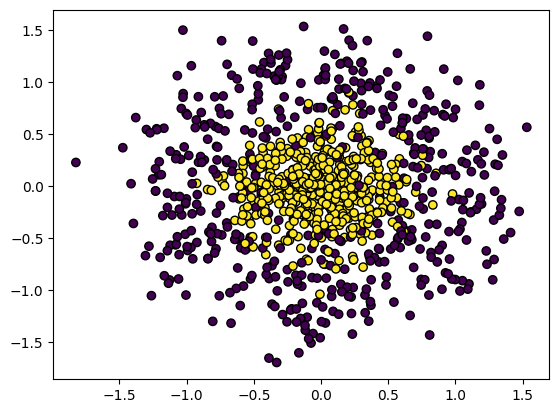

In [7]:
# Визуализируйте датасет

plt.scatter(X_circles['x1'], X_circles['x2'], c=y_circles, edgecolors='k')
plt.show()

In [9]:
# Разделите датасет на обучающую (60%) и тестовую (40%) выборки со стратификацией по целевой переменной
# Не забудьте зафиксировать RANDOM_STATE

X_circles_train, X_circles_test, y_circles_train, y_circles_test = train_test_split(X_circles, y_circles, test_size=0.4, stratify=y_circles, random_state=RANDOM_STATE)

In [10]:
# Обучите дерево tree_circles (DecisionTreeClassifier)
# Не забудьте зафиксировать RANDOM_STATE

tree_circles = DecisionTreeClassifier(random_state=RANDOM_STATE)
tree_circles.fit(X_circles_train, y_circles_train)

DecisionTreeClassifier(random_state=42)

In [12]:
# На тестовой выборке постройте отчёт по метрикам классификации для tree_circles

print(classification_report(y_circles_test, tree_circles.predict(X_circles_test), digits=4))

              precision    recall  f1-score   support

           0     0.8049    0.8250    0.8148       200
           1     0.8205    0.8000    0.8101       200

    accuracy                         0.8125       400
   macro avg     0.8127    0.8125    0.8125       400
weighted avg     0.8127    0.8125    0.8125       400



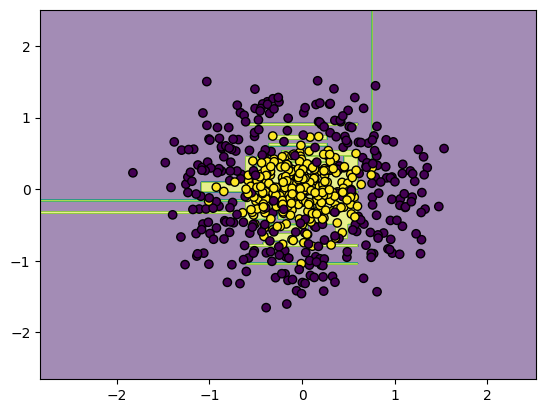

In [13]:
# Визуализируйте границу решений классификатора tree_circles на обучающей выборке

display_decision_boundary(tree_circles.predict, X_circles_train, y_circles_train)

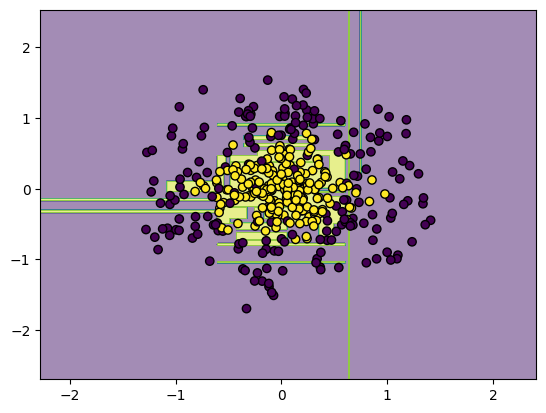

In [15]:
# Визуализируйте границу решений классификатора tree_circles на тестовой выборке

display_decision_boundary(tree_circles.predict, X_circles_test, y_circles_test)

In [16]:
# Обучите случайный лес rf_circles (RandomForestClassifier) с ограничением n_estimators=5
# Не забудьте зафиксировать RANDOM_STATE

rf_circles = RandomForestClassifier(n_estimators=5, random_state=RANDOM_STATE)
rf_circles.fit(X_circles_train, y_circles_train)

RandomForestClassifier(n_estimators=5, random_state=42)

In [17]:
# На тестовой выборке постройте отчёт по метрикам классификации для rf_circles

print(classification_report(y_circles_test, rf_circles.predict(X_circles_test), digits=4))

              precision    recall  f1-score   support

           0     0.8434    0.8350    0.8392       200
           1     0.8366    0.8450    0.8408       200

    accuracy                         0.8400       400
   macro avg     0.8400    0.8400    0.8400       400
weighted avg     0.8400    0.8400    0.8400       400



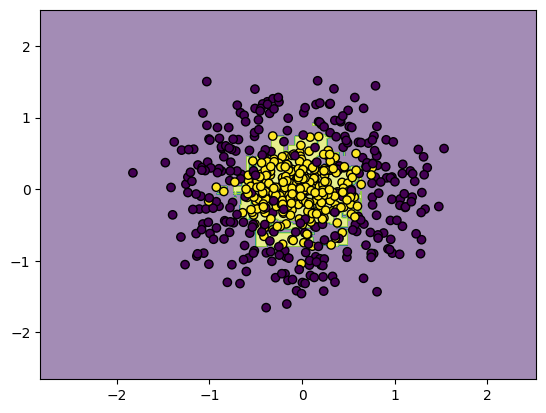

In [18]:
# Визуализируйте границу решений классификатора rf_circles на обучающей выборке

display_decision_boundary(rf_circles.predict, X_circles_train, y_circles_train)

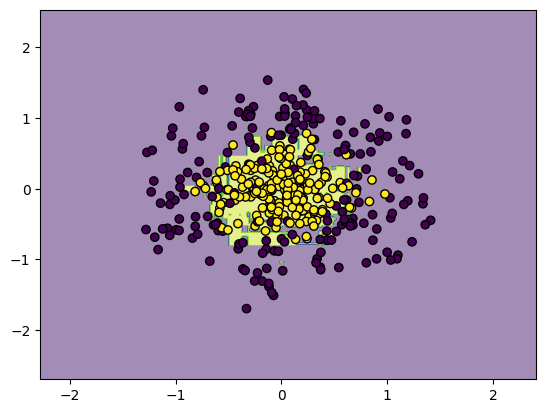

In [19]:
# Визуализируйте границу решений классификатора rf_circles на тестовой выборке

display_decision_boundary(rf_circles.predict, X_circles_test, y_circles_test)

### **Алгоритм построения случайного леса**

Пусть $N$ — количество наблюдений (объектов) в обучающей выборке, $M$ — количество признаков, $m$ — неполное количество случайных признаков при обучении дерева, $k$ — количество деревьев в ансамбле.

* Для каждого дерева решений из $k$ деревьев в ансамбле:

    1. Генерируется бутстрэп-подвыборка путём случайного выбора $N$ объектов из обучающей выборки с возвращением (т.е. некоторые объекты могут повторяться несколько раз).

    2. На бутстрэп-подвыборке обучается дерево решений, причём:

        * При разбиении каждого узла дерева выбирается случайное подмножество признаков мощности $m$ (случайно выбирается $m$ из $M$ признаков).

        * Лучшее разбиение узла определяется только среди выбранных $m$ признаков.

        * Дерево строится до полного исчерпания бутстрэп-подвыборки и не подвергается процедуре прунинга.

### **Датасет *Titanic Dataset***

**Для решения заданий 2 — 4 рассмотрим датасет [Titanic Dataset](https://www.kaggle.com/datasets/yasserh/titanic-dataset).**

Набор данных предназначен для предсказания шансов выживания пассажиров трагически затонувшего в 1912 году корабля "Титаник" на основе имеющейся информации о пассажирах.


Одной из особенностей датасета является наличие **пропущенных значений**.

Целевая переменная — Survived:

* 1 — пассажир выжил (целевой класс).

* 0 — пассажир погиб в катастрофе.

Датасет содержит признаки:

* PassengerId — уникальный идентификатор пассажира.

* Pclass — класс билета (1, 2 или 3).

* Name — имя пассажира.

* Sex — пол пассажира.

* Age — возраст пассажира.

* SibSp — количество братьев, сестёр или супругов на борту.

* Parch — количество родителей или детей на борту.

* Ticket — номер билета.

* Fare — стоимость билета.

* Cabin — номер каюты.

* Embarked — порт посадки (C = Cherbourg, Q = Queenstown, S = Southampton).

### ***Задание 2***

Выполните предобработку датасета (см. код).

Используя обучающую выборку, сгенерируйте 5 бутстрэп-подвыброк ($k=5$), используя функцию [choice](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html) (путём случайного выбора индексов датасета `X_titanic_train` с повторениями).

На каждой из сгенерированных подвыборок обучите дерево DecisionTreeClassifier с неограниченной глубиной и с параметрами:

* **random_state=i**, где $i=0,...,4$ — индекс дерева (индекс подвыборки)

* **max_features=5** — параметр, задающий максимальное число случайных признаков, которое рассматривается для наилучшего разбиения в каждом узле дерева.

Используя обученные деревья решений, предскажите вероятности выживания пассажиров **в тестовой выборке** (запишите предсказанные вероятности в `titanic_trees_y_test_proba`) и посчитайте AUC для предсказания каждого из деревьев решений в отдельности.

Рассчитайте среднее значение AUC, если прогноз на тестовой выборке осуществляется каждым деревом по отдельности.

Рассматривая обученные деревья как ансамбль, постройте прогноз вероятностей для этого ансамбля (случайного леса) **на тестовой выборке** — **усредните (найдите среднее) значения вероятностей выживания**, предсказанные деревьями, входящими в ансамбль.

Рассчитайте значение AUC для прогноза ансамбля (случайного леса) на тестовой выборке.

Обучите модель случайного леса `rf_titanic_5` (RandomForestClassifier) c параметром n_estimators=5 (5 деревьев).

Рассчитайте AUC модели `rf_titanic_5` на **тестовой выборке**.

Сравните значения AUC модели `rf_titanic_5`, среднего AUC для деревьев и AUC ансамбля (случайного леса).

In [20]:
# Считайте набор данных

df_titanic = pd.read_csv('titanic.csv')
df_titanic

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [21]:
# Удалите колонки, не несущие существенной информации: PassengerId, Name, Ticket, Cabin

df_titanic = df_titanic.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])

In [23]:
# Убедитесь, что в датасете присутствуют пропуски в данных

df_titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


In [24]:
# Посчитайте доли пропусков во всей выборке

titanic_nan_info = pd.DataFrame({'NaN share': df_titanic.isnull().mean()})
titanic_nan_info = titanic_nan_info[titanic_nan_info['NaN share'] != 0.0]

In [25]:
titanic_nan_info

,NaN share
Age,0.198653
Embarked,0.002245


<Axes: >

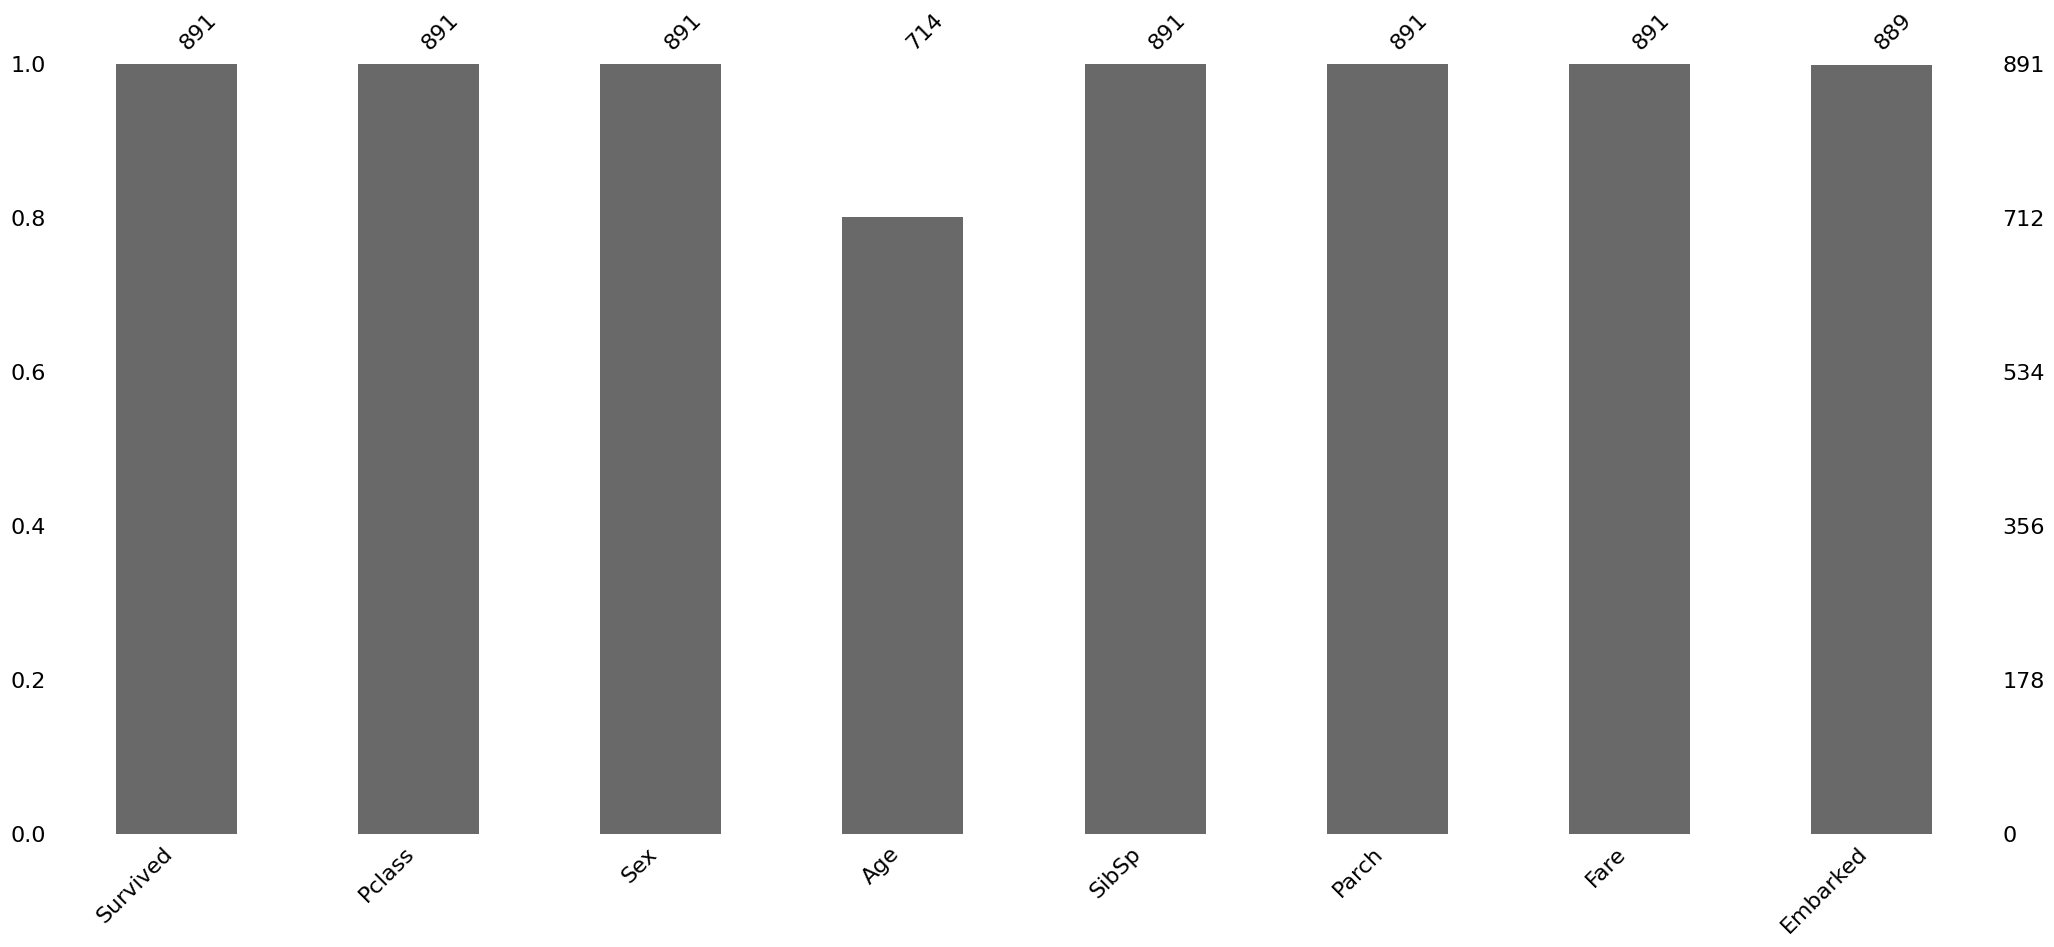

In [26]:
# Выполните визуальный анализ пропущенных значений во всей выборке с помощью msno.bar

msno.bar(df_titanic)

<Axes: >

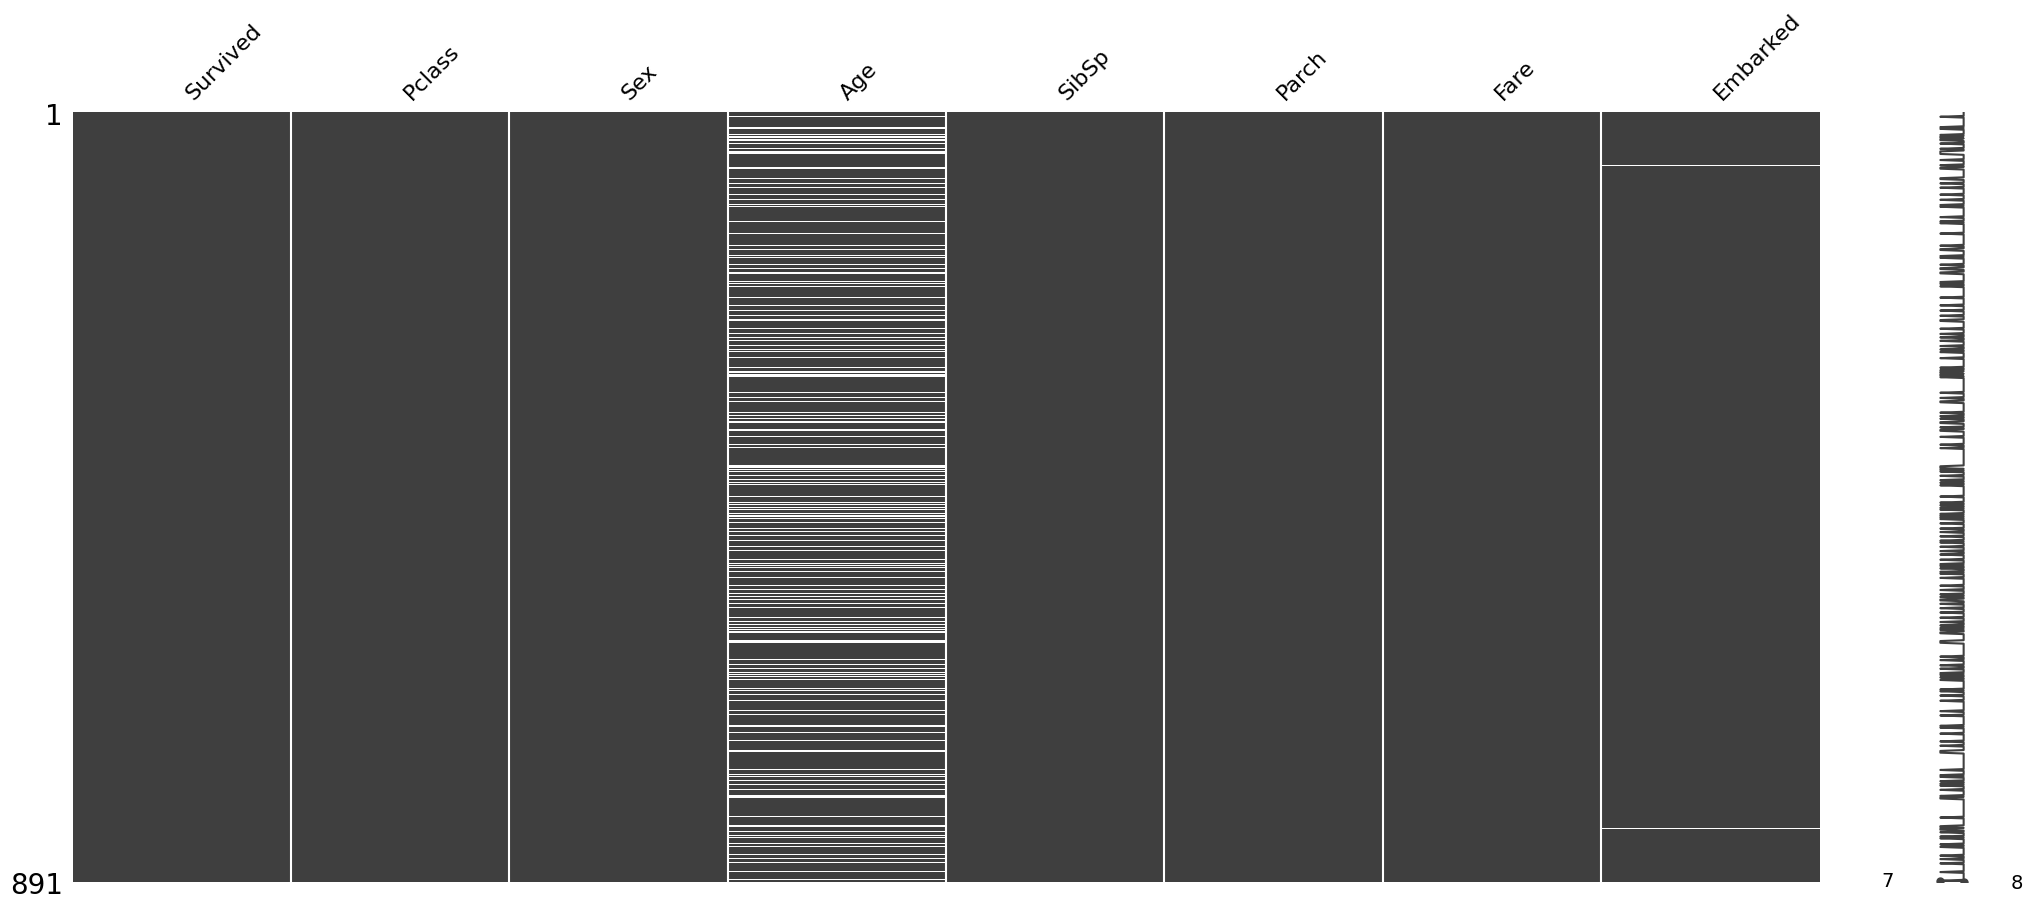

In [28]:
# Выполните визуальный анализ пропущенных значений в обучающей выборке с помощью msno.matrix

msno.matrix(df_titanic)

In [29]:
# Создайте список категориальных переменных (не включая целевую переменную)

titanic_cat_feat = ['Pclass', 'Sex', 'Embarked']

In [30]:
# Выделите объясняемый фактор в отдельную переменную

X_titanic, y_titanic = df_titanic.drop(columns='Survived'), df_titanic['Survived']

In [32]:
# Закодируйте категориальные признаки числами 0 и 1 с помощью OneHotEncoder

titanic_encoder = OneHotEncoder(sparse_output=False, drop='first').set_output(transform='pandas')

X_titanic_encoded = titanic_encoder.fit_transform(X_titanic[titanic_cat_feat])
X_titanic = X_titanic.join(X_titanic_encoded).drop(columns=titanic_cat_feat)

In [33]:
X_titanic

,Age,SibSp,Parch,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,Embarked_nan
0,22.0,1,0,7.2500,0.0,1.0,1.0,0.0,1.0,0.0
1,38.0,1,0,71.2833,0.0,0.0,0.0,0.0,0.0,0.0
2,26.0,0,0,7.9250,0.0,1.0,0.0,0.0,1.0,0.0
3,35.0,1,0,53.1000,0.0,0.0,0.0,0.0,1.0,0.0
4,35.0,0,0,8.0500,0.0,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
886,27.0,0,0,13.0000,1.0,0.0,1.0,0.0,1.0,0.0
887,19.0,0,0,30.0000,0.0,0.0,0.0,0.0,1.0,0.0
888,NaN,1,2,23.4500,0.0,1.0,0.0,0.0,1.0,0.0
889,26.0,0,0,30.0000,0.0,0.0,1.0,0.0,0.0,0.0


In [34]:
# Разделите датасет на обучающую (60%) и тестовую (40%) выборки со стратификацией по целевой переменной
# Не забудьте зафиксировать RANDOM_STATE

X_titanic_train, X_titanic_test, y_titanic_train, y_titanic_test = train_test_split(X_titanic, y_titanic, test_size=0.4, stratify=y_titanic, random_state=RANDOM_STATE)

In [35]:
# Используя обучающую выборку, сгенерируйте 5 бутстрэп-подвыброк, используя функцию choice

# Не забудьте зафиксировать RANDOM_STATE (с помощью переменной rng)
rng = np.random.RandomState(RANDOM_STATE)

k = 5 # Число деревьев в ансамбле (число бутстрэп-подвыброк)

train_N = len(X_titanic_train) # Размер обучающей выборки

train_idx = list(range(train_N)) # Список с индексами наблюдений обучающей выборки

# Выполните случайный выбор индексов train_idx с повторениями
titanic_bootstraps = [rng.choice(train_idx, size=train_N, replace=True) for _ in range(k)]

In [53]:
# На каждой из бутстрэп-подвыборок обучите дерево DecisionTreeClassifier с неограниченной глубиной и с параметрами
#   random_state=i
#   max_features=5
# Для каждого дерева используйте отдельную бутстрэп-подвыборку
# После построения каждого дерева предскажите вероятности выживания пассажиров в тестовой выборке и посчитайте AUC

titanic_trees_y_test_proba = [] # Список для записи векторов предсказаний деревьев
titanic_trees_roc_auc = [] # Список для записи AUC деревьев

for i in range(k):

    X_titanic_fold_train = X_titanic_train.iloc[titanic_bootstraps[i]]
    y_titanic_fold_train = y_titanic_train[X_titanic_fold_train.index]

    tree_titanic_fold = DecisionTreeClassifier(random_state=i, max_features=5).fit(X_titanic_fold_train, y_titanic_fold_train)

    y_test_proba_tree_titanic_fold = tree_titanic_fold.predict_proba(X_titanic_test)[:,1]
    titanic_trees_y_test_proba.append(y_test_proba_tree_titanic_fold)

    roc_auc_tree_titanic_fold = roc_auc_score(y_titanic_test, y_test_proba_tree_titanic_fold)
    titanic_trees_roc_auc.append(roc_auc_tree_titanic_fold)

    print('AUC дерева {}: {:.4f}'.format(i, roc_auc_tree_titanic_fold))

titanic_trees_y_proba = np.array(titanic_trees_y_test_proba)

AUC дерева 0: 0.7563
AUC дерева 1: 0.7271
AUC дерева 2: 0.7767
AUC дерева 3: 0.7172
AUC дерева 4: 0.7004


In [54]:
# Удостоверьтесь, что размерность массива titanic_trees_y_proba — (5, 357)

titanic_trees_y_proba.shape

(5, 357)

In [58]:
# Рассчитайте среднее значение AUC, если прогноз на тестовой выборке осуществляется каждым деревом по отдельности

sum(titanic_trees_roc_auc)/len(titanic_trees_roc_auc)

np.float64(0.735537491705375)

In [64]:
# Посчитайте прогноз случайного леса как усреднённое значение вероятностей, предсказанных деревьями ансамбля

y_test_proba_forest_titanic = np.mean(titanic_trees_y_proba, axis=0)

In [65]:
# Рассчитайте значение AUC для прогноза ансамбля (случайного леса) на тестовой выборке

roc_auc_score(y_titanic_test, y_test_proba_forest_titanic)


np.float64(0.824386197743862)

In [66]:
# Обучите модель RandomForestClassifier c параметром n_estimators=5
# Не забудьте зафиксировать RANDOM_STATE

rf_titanic_5 = RandomForestClassifier(n_estimators=5, random_state=RANDOM_STATE)
rf_titanic_5.fit(X_titanic_train, y_titanic_train)

RandomForestClassifier(n_estimators=5, random_state=42)

In [67]:
# Рассчитайте AUC модели rf_titanic_5 на тестовой выборке

roc_auc_score(y_titanic_test, rf_titanic_5.predict_proba(X_titanic_test)[:,1])

np.float64(0.8344890510948905)

### **RandomizedSearchCV**

[RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) — метод подбора оптимальных гиперпараметров модели, суть которого состоит в переборе случайных комбинаций значений параметров из заданных диапазонов или распределений вместо полного перебора всех возможных комбинаций (как это реализовано в GridSearchCV).

**RandomizedSearchCV и GridSearchCV**:

* **RandomizedSearchCV** выбирает комбинации случайно. Это снижает вычислительные затраты и позволяет находить приемлемые (иногда лучшие) гиперпараметры при меньших вычислительных затратах. **Параметр n_iter** указывает число случайных комбинаций гиперпараметров, которые будут протестированы в процессе подбора.

* **GridSearchCV** перебирает все комбинации значений гиперпараметров. Это гарантирует нахождение результата внутри сетки, но требует много времени, особенно при большом числе параметров или возможных значений.

Подробнее можно изучить по **ссылке:**

* [Рандомизированная оптимизация параметров | scikit-learn.ru](https://scikit-learn.ru/stable/modules/grid_search.html#randomized-parameter-search)

### ***Задание 3***

**ВНИМАНИЕ:** Для решения этого задания используйте:

* Обучающую и тестовую выборку из задания 2: `X_titanic_train`, `X_titanic_test`, `y_titanic_train`, `y_titanic_test`.

На обучающей выборке обучите две модели, предварительно подобрав оптимальные значения гиперпараметров обучения **с помощью RandomizedSearchCV** (n_iter=50 — 50 итераций):

* `tree_titanic` — дерево DecisionTreeClassifier.

* `rf_titanic` — случайный лес RandomForestClassifier.

Выведите оптимальные гиперпараметры обучения моделей `tree_titanic` и `rf_titanic` и номера итераций, на которых были достигнуты оптимальные комбинации параметров в рамках подбора с помощью RandomizedSearchCV.

Для моделей `tree_titanic` и `rf_titanic` **на тестовой выборке** постройте отчёт по метрикам классификации и рассчитайте значения AUC.

In [68]:
# Обучите модель tree_titanic с оптимальными гиперпараметрами
# Оптимальные гиперпараметры обучения подберите с помощью RandomizedSearchCV
# Не забудьте зафиксировать RANDOM_STATE

params = {
    'max_depth': range(5, 15),
    'min_samples_split': range(2, 10),
    'min_samples_leaf': range(2, 10),
}
n_iter = 50
scoring = 'roc_auc'
cv = 5

cv_tree_titanic = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(random_state=RANDOM_STATE),
    param_distributions=params,
    n_iter=n_iter,
    scoring=scoring,
    cv=cv,
    random_state=RANDOM_STATE
).fit(X_titanic_train, y_titanic_train)

tree_titanic = cv_tree_titanic.best_estimator_

In [69]:
# Выведите оптимальные гиперпараметры обучения tree_titanic и номер итерации, на котором они были достигнуты

print(f'Оптимальные параметры DecisionTreeClassifier на итерации {cv_tree_titanic.best_params_}: {cv_tree_titanic.best_index_}')

Оптимальные параметры DecisionTreeClassifier на итерации {'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 5}: 38


In [75]:
# Постройте отчёт по метрикам классификации для модели tree_titanic на тестовой выборке

print(classification_report(y_titanic_test, tree_titanic.predict(X_titanic_test)))

              precision    recall  f1-score   support

           0       0.79      0.93      0.85       220
           1       0.84      0.61      0.70       137

    accuracy                           0.80       357
   macro avg       0.81      0.77      0.78       357
weighted avg       0.81      0.80      0.80       357



In [76]:
# Рассчитайте значение метрики AUC для модели tree_titanic на тестовой выборке

roc_auc_score(y_titanic_test, tree_titanic.predict_proba(X_titanic_test)[:,1])

np.float64(0.8401625746516259)

In [78]:
# Обучите модель rf_titanic с оптимальными гиперпараметрами
# Оптимальные гиперпараметры обучения подберите с помощью RandomizedSearchCV
# Не забудьте зафиксировать RANDOM_STATE

params = {
    'n_estimators': range(5, 200),
    'min_samples_split': range(2, 10),
    'min_samples_leaf': range(2, 10),
}
n_iter = 50
scoring = 'roc_auc'
cv = 5

cv_rf_titanic = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=RANDOM_STATE),
    param_distributions=params,
    n_iter=n_iter,
    scoring=scoring,
    cv=cv,
    random_state=RANDOM_STATE
).fit(X_titanic_train, y_titanic_train)

rf_titanic = cv_rf_titanic.best_estimator_

In [79]:
# Выведите оптимальные гиперпараметры обучения rf_titanic и номер итерации, на котором они были достигнуты

print(f'Оптимальные параметры DecisionTreeClassifier на итерации {cv_rf_titanic.best_params_}: {cv_rf_titanic.best_index_}')

Оптимальные параметры DecisionTreeClassifier на итерации {'n_estimators': 58, 'min_samples_split': 8, 'min_samples_leaf': 8}: 17


In [80]:
# Постройте отчёт по метрикам классификации для модели rf_titanic на тестовой выборке

print(classification_report(y_titanic_test, rf_titanic.predict(X_titanic_test)))

              precision    recall  f1-score   support

           0       0.80      0.97      0.88       220
           1       0.93      0.61      0.74       137

    accuracy                           0.83       357
   macro avg       0.87      0.79      0.81       357
weighted avg       0.85      0.83      0.83       357



In [81]:
# Рассчитайте значение метрики AUC для модели rf_titanic на тестовой выборке

roc_auc_score(y_titanic_test, rf_titanic.predict_proba(X_titanic_test)[:,1])

np.float64(0.8605673523556736)

### **Isolation Forest**

Isolation Forest — это алгоритм машинного обучения без учителя (unsupervised machine learning), предназначенный для обнаружения аномалий. В отличие от методов, основанных на расстояниях или плотностях, Isolation Forest **использует ансамбль решающих деревьев** для изоляции аномальных точек. Ключевая идея этого алгоритма состоит в том, что аномальные наблюдения можно "изолировать" за меньшее число шагов, чем "обычные" данные, поскольку аномальные наблюдения встречаются редко и имеют необычные значения признаков.

Для определения аномальных значений в Isolation Forest используется **оценка аномальности**:

$$s(x,n)=2^{-\frac{\mathbb{E}(h(x))}{c(x)}}$$

где $\mathbb{E}(h(x))$ — средняя глубина (число шагов до изоляции наблюдения) по всем деревьям, $c(x)$ — нормирующая константа (зависит от размера данных).

Подробнее можно изучить по **ссылке:**

* [How to perform anomaly detection with the Isolation Forest algorithm | towardsdatascience.com](https://towardsdatascience.com/how-to-perform-anomaly-detection-with-the-isolation-forest-algorithm-e8c8372520bc/)

### **Датасет *Credit Card Fraud Detection***

**Для решения задания 4 рассмотрим датасет [Credit Card Fraud Detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud).**

Датасет предназначен для обнаружения мошеннических операций (фрод-операций) с кредитными картами. В нем собраны данные по транзакциям, совершенным европейскими владельцами карт за два дня в сентябре 2013 года. Данные о транзакциях представлены в виде числовых переменных, полученных в результате преобразования методом главных компонент (PCA).

Целевая переменная — Class (метка мошеннической операции):

* 1 — фрод-транзакция (аномальное значение).

* 0 — транзакция не является мошеннической.

Датасет характеризуется сильным дисбалансом классов (мошенничество — очень редкое событие): среди 284807 транзакций было выявлено 492 фрод-операций (0.172% от всех транзакций).

### ***Задание 4***

Обучите модель `if_fraud` (IsolationForest) **на всей выборке** c 500 деревьями в ансамбле и определите аномальные наблюдения в выборке.

Рассматривая задачу как задачу классификации, где **аномальное значение соответствует случаю мошенничества (Class = 1)**, на всей выборке для модели `if_fraud` постройте матрицу ошибок и отчёт по метрикам классификации. Рассчитайте долю мошеннических транзакций, которую смогла выявить модель.

**ВНИМАНИЕ:** Поскольку алгоритм Isolation Forest относится к классу задач машинного обучения без учителя, при обучении модели метки классов (вектор истинных значений объясняемой переменной) не используются. Метки классов нужны в рамках данной задачи с целью оценки того, насколько точно модель Isolation Forest смогла выявить мошеннические операции среди всех транзакций.

*Важным параметром в модели IsolationForest является параметр contamination. Он определяет **ожидаемую долю аномалий в данных**, то есть то, сколько процентов объектов модель должна считать "аномальными" после обучения. В рамках данного задания рассматривается стандартное значение contamination.*

In [ ]:
# Считайте набор данных

df_fraud = pd.read_csv('creditcard.csv')
df_fraud

In [ ]:
# Выделите объясняемый фактор в отдельную переменную

X_fraud, y_fraud = ...

In [ ]:
# Обучите модель if_fraud с 500 деревьями в ансамбле
# Метки классов y_fraud не используются при обучении
# Не забудьте зафиксировать RANDOM_STATE

if_fraud = ...

In [ ]:
# С помощью модели if_fraud определите аномальные наблюдения
#   1 — не аномальное наблюдение
#   -1 — аномальное наблюдение

pred_if_fraud = ...
np.unique(pred_if_fraud, return_counts=True)

In [ ]:
# Перейдите от прогноза аномальных наблюдений к целевой переменной:
#   1 (не аномальное наблюдение) —> 0 (обычная транзакция)
#   -1 (аномальное наблюдение) —> 1 (мошенническая транзакция)

y_pred_if_fraud = ...

In [ ]:
# Постройте матрицу ошибок

cf_matrix = ...
plt.figure(figsize=(6, 4))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')
ax.set_title('Confusion Matrix\n')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
plt.show()

In [ ]:
# Постройте отчёт по метрикам классификации

...

In [ ]:
# Рассчитайте долю мошеннических транзакций, которую смогла выявить модель.

...